# Modul-Importe

In [1]:
import modules
import model_io
import importlib.util as imp
import numpy
import numpy as np
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis
import matplotlib.pyplot as plt
import sklearn.datasets

# Datensätze

In [2]:
def generate_dataset(name='xor', D=2, N=2000):
    np.random.seed(1234) # "Startwert" für zufallsngenerator -> reproduzierbare daten
    # Generated datasets should be N x D - shaped, along with
    if name == 'xor':
        return data_xor(D,N)
    if name == 'four':
        return data_four(D,N)
    if name == 'three':
        return data_three(D,N)
    if name == 'circles':
        return data_circles(D,N)
    if name == 'moons':
        return data_moons(D,N)
    else:
       raise ValueError('Unbekannter Datensatzname "{}"'.format(name))

def data_moons(D,N):
    X, Y = sklearn.datasets.make_moons(n_samples=N, noise=0.05)
    Y = np.array(Y) == 1
    Y = (np.vstack((Y, np.invert(Y)))*1.0).T # and [NxC] labels
    X = np.array(X)
    Y = np.array(Y)
    return X, Y, 2
    
def data_circles(D,N):
    X, Y = sklearn.datasets.make_circles(n_samples=N, noise=0.05)
    Y = np.array(Y) == 1
    Y = (np.vstack((Y, np.invert(Y)))*1.0).T # and [NxC] labels
    X = np.array(X)
    Y = np.array(Y)
    return X, Y, 2

def data_three(D,N):
    X, Y = sklearn.datasets.make_blobs(n_samples=N, centers=3, n_features=2, random_state=1)
    X = np.array(X)
    Y0 = np.array(Y) == 0
    Y1 = np.array(Y) == 1
    Y2 = np.array(Y) == 2
    Y = (np.vstack((Y0, Y1, Y2))*1.0).T # and [NxC] labels
    return X, Y, 3

def data_xor(D,N):
    #this is the XOR problem.
    X = np.random.rand(N,D) #we want [NxD] data
    X = (X > 0.5)*1.0
    Y = X[:,0] == X[:,1]
    Y = (np.vstack((Y, np.invert(Y)))*1.0).T # and [NxC] labels

    X += np.random.randn(N,D)*0.1 # add some noise to the data.
    return X, Y, 2

def data_four(D,N):
    #this is the XOR problem.
    X = np.random.rand(N,D) #we want [NxD] data
    X = (X > 0.5)*1.0
    Y0 = (X[:,0] == 0) * (X[:,1] == 0)
    Y1 = (X[:,0] == 1) * (X[:,1] == 0)
    Y2 = (X[:,0] == 0) * (X[:,1] == 1)
    Y3 = (X[:,0] == 1) * (X[:,1] == 1)

    Y = (np.vstack((Y0, Y1, Y2, Y3))*1.0).T # and [NxC] labels
    X += np.random.randn(N,D)*0.1 # add some noise to the data.
    return X, Y, 4
    

def data_eval(X, n_per_dim=100, border=0.1):
    # generate test grid data matching the training data, with a bit of extra space around
    assert X.shape[1] == 2, "X muss in R^2 sein, um grafisch evaluiert zu werden."
    
    # analyze min/max values
    xmin = np.amin(X, axis=0)
    xmax = np.amax(X, axis=0)
    val_range = np.abs(xmax-xmin)

    # create exhaustive coordinate grid
    x = np.linspace(xmin[0] - val_range[0]*border, xmax[0] + val_range[0]*border, n_per_dim)
    y = np.linspace(xmin[1] - val_range[1]*border, xmax[1] + val_range[1]*border, n_per_dim)
    xx, yy = np.meshgrid(x, y)
    
    #return as 2d-Cordinates and grid coordinates
    Xval = np.concatenate([xx[...,None], yy[...,None]], axis=2)
    Xval = np.reshape(Xval, (n_per_dim**2, 2))
    return Xval, (xx, yy)


# Hilfsfunktionen

In [3]:
def analyze_decision_boundary(neuralnet, Xtrain, Ytrain, Xeval, gridcoords):
    
     # Auswertung auf Trainingsdaten!
    accuracy = np.mean(np.argmax(nn.forward(Xtrain), axis=1) == np.argmax(Ytrain, axis=1))
    if not np == numpy: accuracy = np.asnumpy(accuracy)
    title = 'ACC nach {} epochen zu {} iterationen: {:0.4f}%'.format(e, iterations_per_epoch, accuracy*100)
    
    # predict evaluation data with neural net
    Yeval = neuralnet.forward(Xeval)
    
    predictions = np.argmax(Yeval, axis=1)
    levels = np.arange(Yeval.shape[1])
    XX, YY = gridcoords
    # bring predictions to grid shape
    predictions = np.argmax(Yeval, axis=1)
    predictions = np.reshape(predictions, XX.shape)
    
    if not np == numpy: # move data from GPU to CPU for rendering
        Xeval       = np.asnumpy(Xeval)
        predictions = np.asnumpy(predictions)
        levels      = np.asnumpy(levels)
        XX          = np.asnumpy(XX)
        YY          = np.asnumpy(YY)
        Xtrain      = np.asnumpy(Xtrain)
        Ytrain      = np.asnumpy(Ytrain)
        

    # render grid evaluation
    plt.contourf(XX, YY, predictions, alpha=0.5)
    plt.contour(XX, YY, predictions)
    plt.scatter(Xtrain[:,0], Xtrain[:,1], c=numpy.argmax(Ytrain, axis=1))
        
    # plot data
    plt.title(title)
    plt.axis('equal')
    plt.show()


# Neuronales Netz

In [14]:
def build_network(n_classes):
    #build a network
    """ #dreifache anführungsstriche beginnen/beenden "block-kommentare" 
    nn = modules.Sequential(
        [modules.Linear(2,3),
         modules.Tanh(),
         modules.Linear(3,15),
         modules.Tanh(),
         modules.Linear(15,15),
         modules.Tanh(),
         modules.Linear(15,3),
         modules.Tanh(),
         modules.Linear(3, n_classes),
         modules.SoftMax()]
    )
    """
    nn = modules.Sequential([modules.Linear(2,n_classes)])
    return nn

# Training + Evaluation

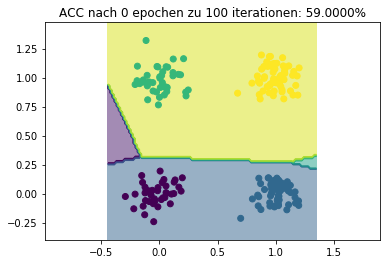

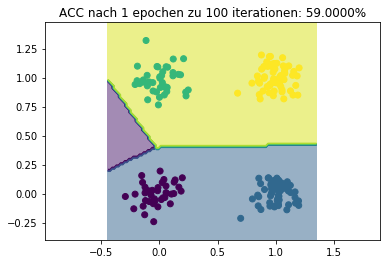

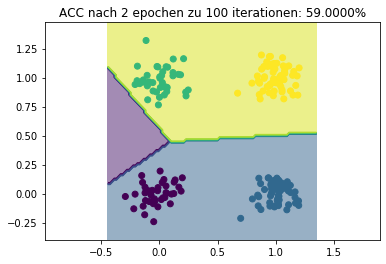

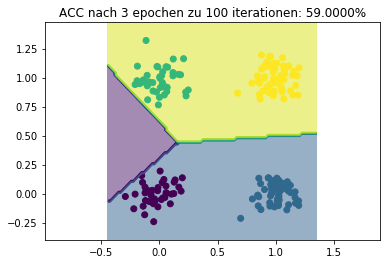

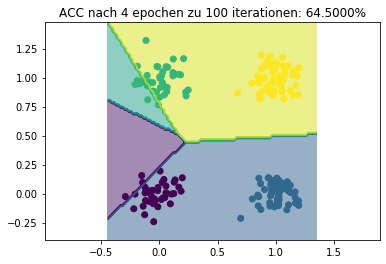

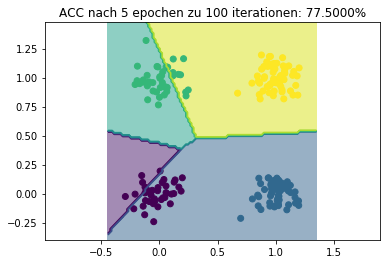

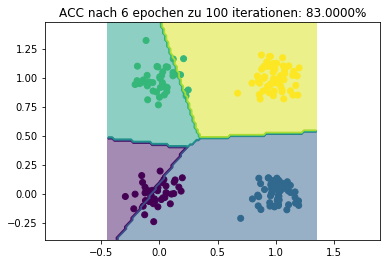

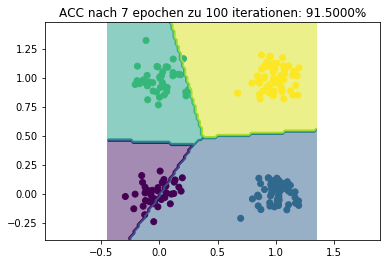

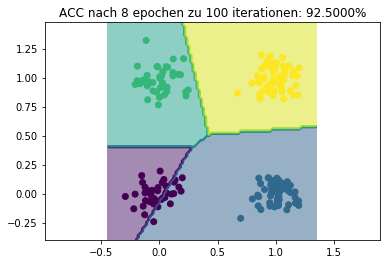

In [ ]:
epochs = 20
batchsize = 10
lrate = 0.001
iterations_per_epoch = 100
netzwerkname = 'test_1'
datensatz = 'four' # 'three',  'four','xor', 'circles', 'moons'

# generiere Trainingsdaten und Evaluierungsdaten
X,Y,n_classes = generate_dataset(name=datensatz, N=200)
Xtest, testGrid = data_eval(X)

# generiere neues Netzwerk:
nn = build_network(n_classes)



# Trainiere ein Netzwerk für mehrere Epochen,
# mit der gleichen Anzahl an iterationen pro Epoche.
# Zwischen den Epochen wird das Netz ausgewertet und die Ergebnisse werden visualisiert

for e in range(epochs):
    # train the network for one epoch.
    nn.train(X,Y, batchsize=batchsize, lrate=lrate, iters=iterations_per_epoch, status=iterations_per_epoch, silent=True)
        
    # (Grafische) Analyse der Entscheidungsgrenze
    analyze_decision_boundary(neuralnet=nn, Xtrain=X, Ytrain=Y, Xeval=Xtest, gridcoords = testGrid)
    

#speichere trainiertes netzwerk
model_io.write(nn, './{}.txt'.format(netzwerkname))
if not np == numpy: nn.to_cupy()